In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import sys
sys.path.append("../utils")
sys.path.append("../data/")
from dataconfig import *
from utils import *
import numpy as np 

{'SPARSE_FEATURES': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'], 'DENSE_FEATURES': ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13'], 'label': ['label']}


In [2]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
spase_feature_names = DATA_CONFIG['SPARSE_FEATURES']
dense_feature_names = DATA_CONFIG['DENSE_FEATURES']
label_feature_names = DATA_CONFIG['label']


In [4]:
import platform
if platform.system() != 'Windows':
    dataset = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/train_criteo_5w_rows.tfrecord", 512)
    eval_data = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/test_criteo_1w_rows.tfrecord", 512)
    valid_data = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/valid_criteo_1w_rows.tfrecord", 512)
else:
    dataset = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/train_criteo_200w_rows.tfrecord", 512)
    eval_data = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/test_criteo_20w_rows.tfrecord", 512)
    valid_data = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/valid_criteo_20w_rows.tfrecord", 512)

# 定义 inputs
inputs = { name:keras.Input(shape=(1,), name=name, dtype=tf.float32) for name in dense_feature_names }
inputs.update({
    name:keras.Input(shape=(1,), name=name, dtype=tf.string) for name in spase_feature_names
})


In [5]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model 

class FM(Layer):
    def __init__(self):
        super().__init__()

    def call(self, input_embeddings):  # input_embeddings shape : batch x n x embedding_dim
        sum_squre = tf.reduce_sum(input_embeddings, axis = 1 , keepdims=True) * tf.reduce_sum(input_embeddings, axis = 1 , keepdims=True)
        squre_sum = tf.reduce_sum(input_embeddings * input_embeddings, axis = 1, keepdims=True)

        cross_term = sum_squre - squre_sum
        return 0.5 * tf.reduce_sum(cross_term, axis=2, keepdims=False )
        
class denseLayer(Layer):
    def __init__(self, units):
        super().__init__()
        
        self.dnn = keras.Sequential([keras.layers.Dense(unit, activation='relu') for unit in units])
        self.dnn.add(keras.layers.Dense(1))
    def call(self, x):
        return self.dnn(x)

class deepFM(Model):
    def __init__(self, inputs, sparse_features, dense_features):
        self.embedding_dict = {} 
        self.hash_dict = {}
        num_bins = 1000000
        self.sparse_features = sparse_features
        self.dense_features = dense_features
        
        for feat in sparse_features:
            hash_dict[feat] = layers.Hashing(num_bins = num_bins, mask_value='NaN')
            embedding_dict[feat] = layers.Embedding(num_bins, 8, mask_zero = True)
        
            
        self.dnn = denseLayer()
        self.fm = FM()
        self.concat_layer = layers.Concatenate()

    def call(self, inputs):
        embeddings = []
        dense_features = []
        for name, v in inputs.items():
            if name in hash_dict:
                tp_embedding = self.embedding_dict[name](self.hash_dict[name](v))
                embeddings.append(tf.squeeze(tp_embedding, axis = 1))
            else:
                dense_features.append(v)
        fm_logit = self.fm(embeddings)

        concat_dense_embedding_dense = self.concat_layer(embeddings + dense_features, axis = 1)

        logit = self.dnn(concat_dense_embedding_dense)
        return logit + fm_logit
        

In [6]:

numeric_inputs = { name:value for name, value in inputs.items() if value.dtype == tf.float32 }
x = layers.Concatenate()(list(numeric_inputs.values()))

preprocessed_inputs = [x]
num_bins = 10000
embedding_dim = 8
sparse_inputs = { name:value for name, value in inputs.items() if value.dtype == tf.string }
for name, input in sparse_inputs.items():

    lookup = keras.layers.Hashing(num_bins=num_bins)
    embedding_layer = layers.Embedding(input_dim=num_bins, output_dim=8)
    x = lookup(input)
    x = embedding_layer(x)
    x = tf.squeeze(x, axis = 1)
    preprocessed_inputs.append(x)

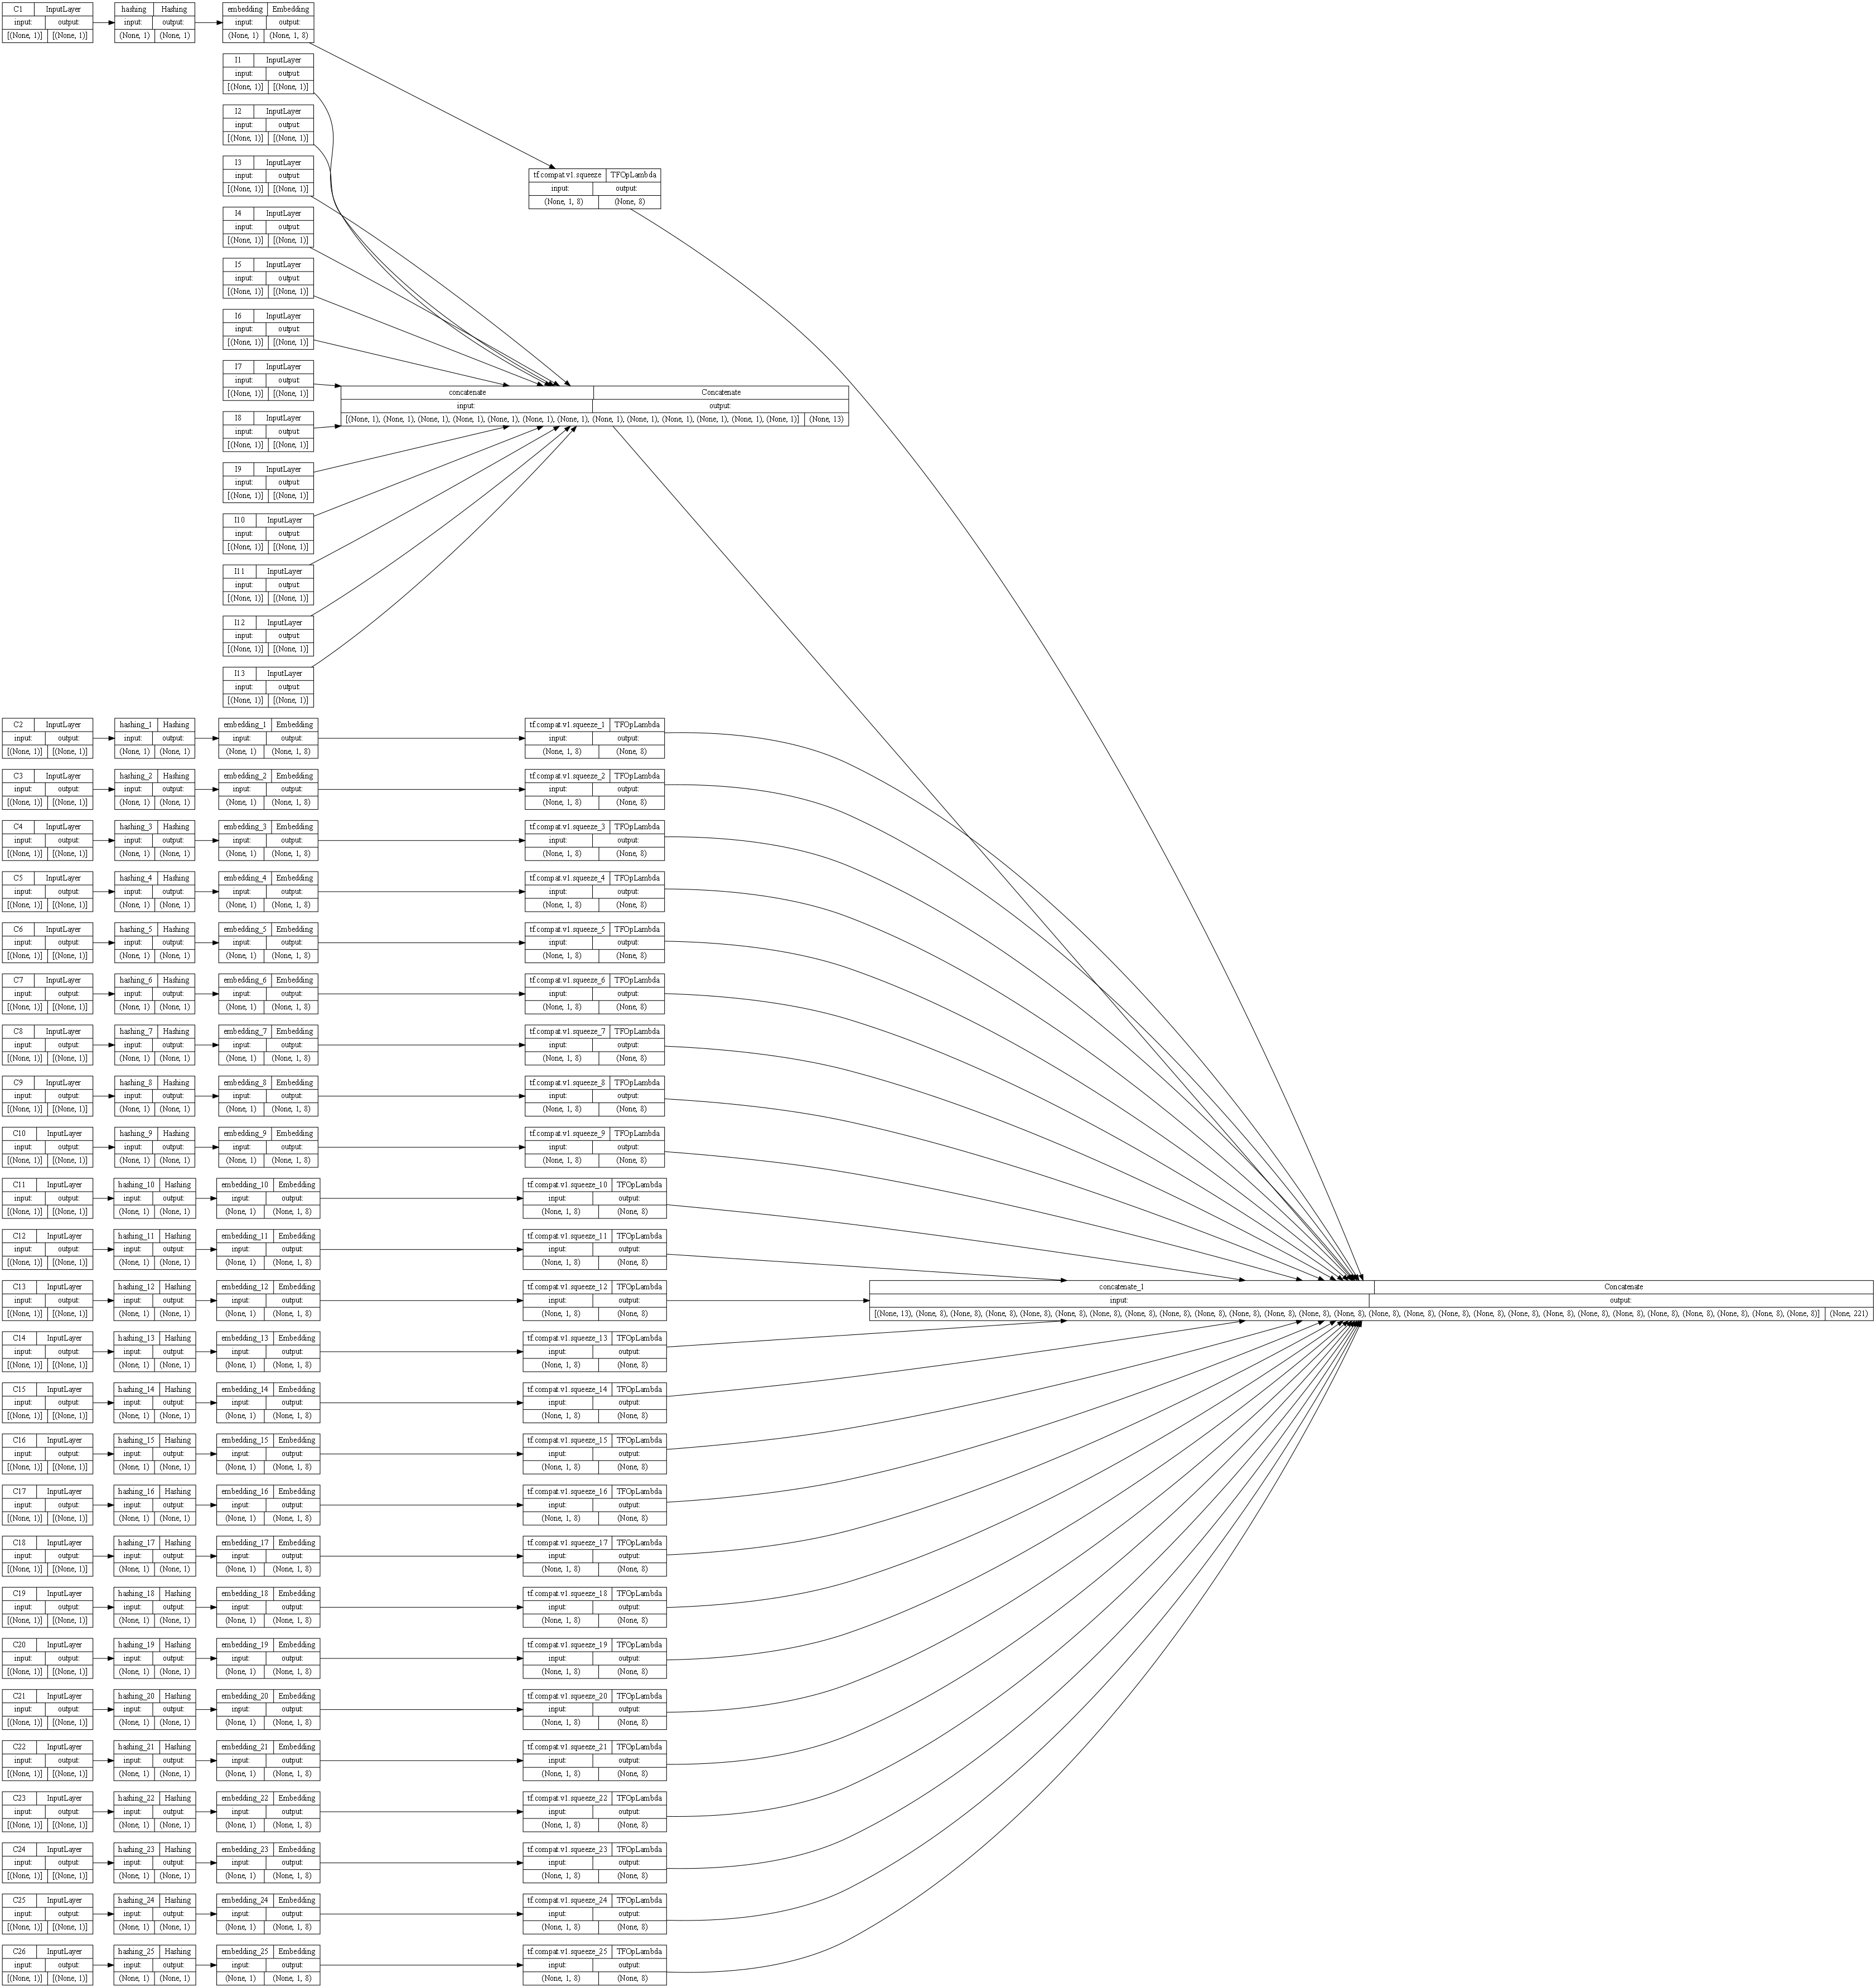

In [7]:
results = layers.Concatenate()(preprocessed_inputs)
process_model = keras.Model(inputs, results)
tf.keras.utils.plot_model(model = process_model, rankdir='LR',dpi = 75,
                         show_shapes=True )

In [8]:
import sys
sys.path.append("..")
from models.dnn_model import *

In [9]:
class Custom_Model2(Model):
    def __init__(self, preprocess_model, units):
        super().__init__()
        self.preprocess_model = preprocess_model
        self.dnn = keras.Sequential()
        for unint in units:
            self.dnn.add(
                layers.Dense(unint, activation='relu')
            )
        self.dnn.add(layers.Dense(1))

    def call(self, inputs):
        x = self.preprocess_model(inputs)
        x = self.dnn(x)
        return tf.sigmoid(x)

    def train_step(self, train_data):

        inputs, label = train_data
        with tf.GradientTape() as tape:
            predict = self(inputs)
            losses = self.loss(label, predict)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(label, predict)
        results = {m.name: m.result() for m in self.metrics}
        return results


In [14]:
model = Custom_Model2(process_model, [1024,1024, 512,256])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= False), optimizer = 'adam',metrics=[tf.keras.metrics.AUC(name='auc')])

In [15]:
def create_tf_dataset(dataset):
    def generator():
        for batch in dataset:
            data = batch
            label = batch.pop('label')
            label = tf.expand_dims(label, 1)
            yield data, label  # 返回 data 和 label 作为一个 tuple
    return tf.data.Dataset.from_generator(generator, output_signature=(
        {
            name:tf.TensorSpec(shape=(None, ), dtype=v.dtype) for name, v in inputs.items()
        },
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    ))

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',  # 监控验证集上的 loss
    patience=3,          # 如果连续 3 轮没有改善，就停止训练
    restore_best_weights=True  # 训练结束后恢复到最优模型
)

In [ ]:
model.fit(create_tf_dataset(dataset), epochs = 20,  validation_data=create_tf_dataset(valid_data), callbacks = [early_stopping])

Epoch 1/20
3907/3907 [==============================] - 121s 30ms/step - auc: 0.6760 - val_loss: 0.5159 - val_auc: 0.6755
Epoch 2/20
3907/3907 [==============================] - 118s 30ms/step - auc: 0.7213 - val_loss: 0.5080 - val_auc: 0.6805
Epoch 3/20
3907/3907 [==============================] - 119s 30ms/step - auc: 0.7459 - val_loss: 0.4861 - val_auc: 0.7435
Epoch 4/20
3907/3907 [==============================] - 119s 30ms/step - auc: 0.7676 - val_loss: 0.5159 - val_auc: 0.6799
Epoch 5/20
 678/3907 [====>.........................] - ETA: 1:27 - auc: 0.7527   

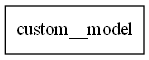

In [23]:
from tensorflow.keras.utils import plot_model

# 假设 model 已经构建完成
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, rankdir='LR')


In [55]:
first_batch = next(iter(dataset))
input_shapes = {name: tf.TensorSpec(shape=(None,) + v.shape[1:], dtype=v.dtype) for name, v in first_batch.items() if name != 'label'}

In [45]:
# 假设你的 model 已经定义好并且训练好了
# 创建一个 AUC 度量
auc_metric = tf.metrics.AUC()

for batch in eval_data:
    data = batch
    label = batch.pop('label')
    label = tf.expand_dims(label, 1)  # 可能需要调整 label 的形状
    model.fit(data, label)
    # 进行预测，获取 logits
    logits = model.predict(data)

    # 将 logits 转换为概率值
    predictions = tf.sigmoid(logits)

    # 更新 AUC 度量
    auc_metric.update_state(label, predictions)

# 获取总的 AUC
total_auc = auc_metric.result().numpy()
print(f'Total AUC: {total_auc}')


13/16 [=======================>......] - ETA: 0s

ValueError: Unexpected result of `train_function` (Empty logs). This could be due to issues in input pipeline that resulted in an empty dataset. Otherwise, please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
model.fit(data, label)

In [25]:
label

<tf.Tensor: shape=(512, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
 